<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

<img src="images/high_res_v_low_res.jpg" width=550px>

## Task 1: Project Overview and Import Libraries

In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.1.0


## Task 2: What are Autoencoders?

<img src="images/autoencoder.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

<h4 align=center>Encoder Architecture</h4>
<img src="images/encoder.png" width=450px align=center>

## Task 3: Build the Encoder

In [2]:
# Function API
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(input_img) # first Convolution layer, 64 layers, 64 is adjustable
# padding='same' ensures to maintain the spatial dimensions of the input and output volumes
# padding='same' will adjust the padding size based on the kernel size
# an activity regularizer is to add a penalty to the loss function during training
# This property is to encourage certain desirable properties in the network
# L1 activity regularizer can set some neuron activities to be 0 and only select important features
l2 = Conv2D(64, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='valid')(l2) 
# padding='valid' means no padding
l4 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='valid')(l5)
l7 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

In [3]:
encoder = Model(input_img, l7)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

## Task 4: Build the Decoder to Complete the Network

<img src="images/decoder.png" width=450px>

In [4]:
l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = add([l14, l2])
decoded = Conv2D(3, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l15)

In [5]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

## Task 5: Create Dataset and Specify Training Routine

In [7]:
# the dataset is a subset of the car class in ImageNet
def train_batches(just_load_dataset=False):

    batches = 256 # batch size

    batch = 0 # number of images in the current batch
    batch_nb = 0 # current index of the batch
    max_batches = -1 # use it to control the number of batches to be trained
    
    ep = 4 # number of epochs

    images = []
    x_train_n = [] # list of current high resolution image
    x_train_down = [] # list of current low resolution image
    
    x_train_n2 = [] # np array of high resolution images
    x_train_down2 = [] # np array of low resolution images
    
    for root, dirnames, filenames in os.walk("/home/rhyme/Desktop/Project/data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath) # read the images
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256)) # resize images
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0)) 
                    # rescale twice to decrease the resolution 
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Task 6: Load the Dataset and Pre-trained Model

In [8]:
x_train_n, x_train_down = train_batches(just_load_dataset=True) # not training for now, just loading

/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [9]:
# If there is warning, it is normal
# If set just_load_dataset = False, it could take hours to train

In [10]:
# load weights of pre-trained models
autoencoder.load_weights('/home/rhyme/Desktop/Project/data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')
# http://localhost:8888/edit/data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5

## Task 7: Model Predictions and Visualizing the Results

In [11]:
# load weights of pre-trained models on the encoder
encoder.load_weights('/home/rhyme/Desktop/Project/data/encoder_weights.hdf5')

In [12]:
# For visualization, we just used the encoder, not the decoder
encoded_imgs = encoder.predict(x_train_down)

In [13]:
encoded_imgs.shape # 256 feature channels, because it is the output of the encoder

(256, 64, 64, 256)

In [14]:
# super resolution one
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0) # between 0 and 1, which is like normalized

In [15]:
image_index = 251 # or just select a random index using np.random.randint(0, 256)

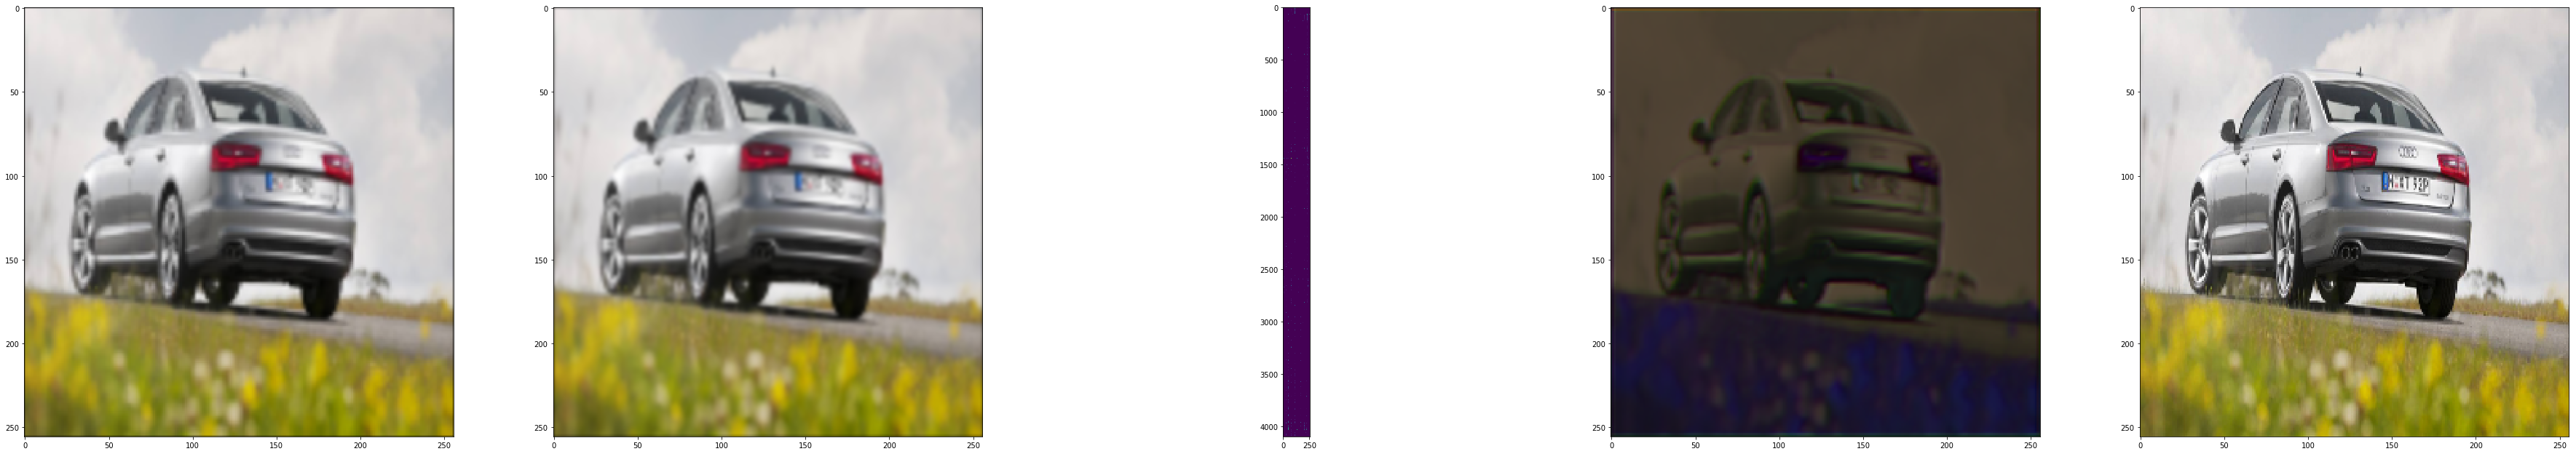

In [16]:
plt.figure(figsize=(128,128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])

i += 1
# plot the output of traditional interpolation methods to show the difference
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation='bicubic')

i += 1
# plot the output of deep learning method which is the autoencoder
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))

i += 1
# plot the output of deep learning method which is the autoencoder
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])

i += 1
# plot the ground truth image - high resolution image
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()